# Ejemplo de uso de los datos de Santa Maria y Stanford

El archivo muestra las siguientes funciones:
1. Cargar datos *tensorflow* de Santa María y Stanford.
2. Dividir datos en entrenamiento y testeo con las clases balanceadas y para un valor de división deseada.
3. Visualizar imágenes de **PET**, **Body CT** y **Torax3d**
Se muestra un ejemplo de uso de carga de los datos de santa maría y Stanford.

**IMPORTANTE**: Se deben descargar los datos de Santa María y de Stanford de la forma en que se indica en el README. Es necesario haber instalado *tensorflow* y *tensorflow_datasets* como se indica en el readme también para cargar los datos.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import resource
import tensorflow_datasets as tfds
import random
import pandas as pd
import cv2

In [2]:
# se cargan los datos de santa maría y stanford
# Para el ejemplo se cargan los datos de los exámenes torax3d, se puede reemplazar con 'pet' o 'body'

sample_dataset, info = tfds.load('santa_maria_dataset/torax3d', with_info=True)
#sample_dataset, info = tfds.load('santa_maria_dataset/pet', with_info=True)
#sample_dataset, info = tfds.load('santa_maria_dataset/body', with_info=True)

2023-10-22 21:02:24.332892: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)



def get_training_testing_sm_datasets(split_val=0.8, random_seed=None):
    '''Crea particiones aleatorias de entrenamiento y testeo balancedas dada el split_val.
    Retorna dos conjuntos de datos, uno de entrenamiento y otro de testeo.'''

    # setea la semilla random
    random.seed(random_seed)

    # Define the positive and negative patients
    pos_patients = [f'sm_{str(i).zfill(3)}' for i in range(1, 13)]
    neg_patients = [f'sm_{str(i).zfill(3)}' for i in range(13, 36)]
    
    # Get the split keys (splits) of the dataset
    split_keys = list(info.splits.keys())
    
    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]
    
    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Calculate the number of patients for training and testing
    train_pos_count = int(split_val * len(pos_patients))
    train_neg_count = int(split_val * len(neg_patients))
    
    # Create the training and testing sets
    training_patients = pos_patients[:train_pos_count] + neg_patients[:train_neg_count]
    testing_patients = pos_patients[train_pos_count:] + neg_patients[train_neg_count:]
    
    # Create dictionaries to hold the training and testing data
    training_data = {patient: sample_dataset[patient] for patient in training_patients}
    testing_data = {patient: sample_dataset[patient] for patient in testing_patients}
    
    
    # Create a generator for the training dataset
    def generate_training_data():
        for patient_id in training_patients:
            patient_data = training_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    training_dataset = tf.data.Dataset.from_generator(
        generate_training_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )
    
    # Create a generator for the training dataset
    def generate_testing_data():
        for patient_id in testing_patients:
            patient_data = testing_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    testing_dataset = tf.data.Dataset.from_generator(
        generate_testing_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )

    return training_dataset, testing_dataset

In [21]:

def visualizeImgMask(img, mask, pet):

    """
  Función para visualizar las imágenes, máscaras y fusión.
  INPUT: imágenes y máscaras como numpy array 3D (numero de imagenes, alto, ancho),
  PET: True or False. Si es True se visualiza en inverso (cmap=gray_r),
  sólo por un tema de convención de la visualización del PET.
    """
    mask = mask.numpy()
    img = img.numpy()

    if(pet == 1):
        f = plt.figure(figsize=(10,10), frameon=True)
        f.add_subplot(1, 3, 1)
        plt.title("PET")
        plt.imshow(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE), cmap='gray_r')
        f.add_subplot(1, 3, 2)
        plt.title("Mask")
        plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE), cmap='Blues')
        f.add_subplot(1, 3, 3)
        plt.title("Fusion")
        plt.imshow(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE), cmap='gray_r')
        plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE), cmap='gnuplot', alpha= 0.6)
        plt.show()

    else:
        f = plt.figure(figsize=(10,10), frameon=True)
        f.add_subplot(1, 3, 1)
        plt.title("CT")
        plt.imshow(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE), cmap='gray')
        f.add_subplot(1, 3, 2)
        plt.title("Mask")
        plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE), cmap='Blues')
        f.add_subplot(1, 3, 3)
        plt.title("Fusion")
        plt.imshow(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE), cmap='gray')
        plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE), cmap='gnuplot', alpha= 0.6)
        plt.show()


2023-10-22 22:40:55.080564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Patient ID: sm_003
Image Exam Shape: (512, 512)
Mask Exam Shape: (512, 512)
Label: 1


2023-10-22 22:40:55.384669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Patient ID: sm_011
Image Exam Shape: (512, 512)
Mask Exam Shape: (512, 512)


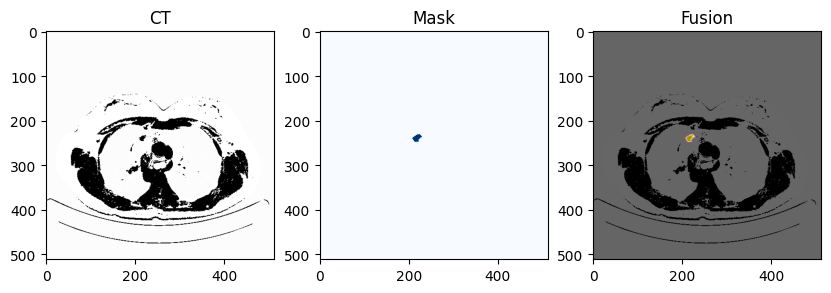

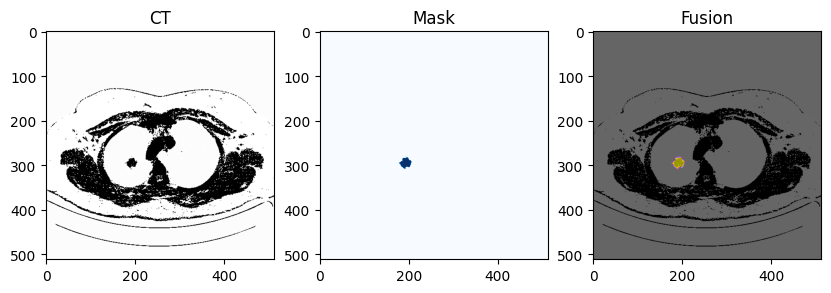

In [25]:
training_ds, testing_ds = get_training_testing_sm_datasets()


# Iterate through the training dataset
img_exam_train, mask_exam_train = None, None
img_exam_test, mask_exam_test = None, None
for patient_id, img_exam_train, mask_exam_train, label in training_ds:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print("Image Exam Shape:", img_exam_train.shape)
    print("Mask Exam Shape:", mask_exam_train.shape)
    print("Label:", label.numpy())
    break


# Iterate through the testing dataset
for patient_id, img_exam_test, mask_exam_test, label in testing_ds:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print("Image Exam Shape:", img_exam_test.shape)
    print("Mask Exam Shape:", mask_exam_test.shape)
    break


visualizeImgMask(img_exam_train, mask_exam_train, pet=False)
visualizeImgMask(img_exam_test, mask_exam_test, pet=False)

## Extraer el ROI de los examenes

In [35]:
def roiExtraction (img,mask,margin):
    """
  Función para extraer el ROI donde se encuentra el tumor en una imagen.
  INPUT: imagen y máscaras numpy array 2D.
  margin: corresponde al número de pixeles como margen por fuera de los pixeles de la máscara.
  OUTPUT: Devuelve el ROI.
  """

    roi_extract = []

    img_instance = img.numpy()
    mask_instance = mask.numpy()
    index = np.where(mask_instance)
    roi = img_instance[np.unique(index[0])[0]-margin:np.unique(index[0])[-1]+margin, np.unique(index[1])[0]-margin: np.unique(index[1])[-1]+margin]
    return roi


(29, 25)


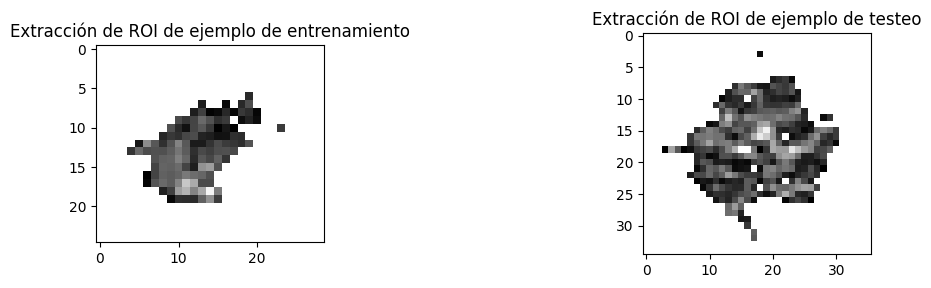

In [39]:
margin = 4
level = 50
window_width = 200

roi_exam_train = roiExtraction(img_exam_train, mask_exam_train, margin)
roi_exam_test = roiExtraction(img_exam_test, mask_exam_test, margin)

f = plt.figure(figsize=(10, 10), frameon=True)
f.add_subplot(1, 3, 1)
plt.title("Extracción de ROI de ejemplo de entrenamiento")

# Correct usage of cv2.rotate()
rotated_image = cv2.rotate(roi_exam_train, cv2.ROTATE_90_CLOCKWISE)

# Assuming 'level' and 'window_width' are properly defined
# and you have a function show_slice_window to display the image with a specific window.
plt.imshow(show_slice_window(rotated_image, level, window_width), cmap='gray')

f.add_subplot(1, 3, 3)
plt.title("Extracción de ROI de ejemplo de testeo")

# Correct usage of cv2.rotate()
rotated_image = cv2.rotate(roi_exam_test, cv2.ROTATE_90_CLOCKWISE)

# Assuming 'level' and 'window_width' are properly defined
# and you have a function show_slice_window to display the image with a specific window.
plt.imshow(show_slice_window(rotated_image, level, window_width), cmap='gray')


## Implementación de K-Fold

In [ ]:
def kfold_sm(k, random_seed=None):
    '''Crea particiones aleatorias de entrenamiento y testeo balancedas dada el split_val.
    Retorna dos conjuntos de datos, uno de entrenamiento y otro de testeo.'''

    # setea la semilla random
    random.seed(random_seed)

    # Define the positive and negative patients
    pos_patients = [f'sm_{str(i).zfill(3)}' for i in range(1, 13)]
    neg_patients = [f'sm_{str(i).zfill(3)}' for i in range(13, 36)]
    
    # Get the split keys (splits) of the dataset
    split_keys = list(info.splits.keys())
    
    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]
    
    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Calculate the number of patients for training and testing
    train_pos_count = int(split_val * len(pos_patients))
    train_neg_count = int(split_val * len(neg_patients))
    
    # Create the training and testing sets
    training_patients = pos_patients[:train_pos_count] + neg_patients[:train_neg_count]
    testing_patients = pos_patients[train_pos_count:] + neg_patients[train_neg_count:]
    
    # Create dictionaries to hold the training and testing data
    training_data = {patient: sample_dataset[patient] for patient in training_patients}
    testing_data = {patient: sample_dataset[patient] for patient in testing_patients}
    
    
    # Create a generator for the training dataset
    def generate_training_data():
        for patient_id in training_patients:
            patient_data = training_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    training_dataset = tf.data.Dataset.from_generator(
        generate_training_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )
    
    # Create a generator for the training dataset
    def generate_testing_data():
        for patient_id in testing_patients:
            patient_data = testing_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    testing_dataset = tf.data.Dataset.from_generator(
        generate_testing_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.uint16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )

    return training_dataset, testing_dataset